# Quiz: Multiple and Polynomial Regression

In this notebook we will continue to use data on house sales in King County to predict house prices using *multiple linear regression* and *polynomial linear regression*. You will:
* Write a function to convert a set of Series from a Pandas frame into a NumPy array
* Write a function to compute the multiple linear regression weights for a list of features using the closed form solution
* Write a function to make predictions of the output given a list of input input features
* Write a function to create a series into a polynomial design matrix
* Explore overfitting and variance by fitting and plotting polynomial models of a given feature (make sure the plots look smooth, not jagged)
* Compare various models for predicting house prices 

#### Load libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=2,suppress=True)
from platform import python_version
print('Using Python',python_version(), 'and NumPy version', np.__version__)
# use WIDER CANVAS:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using Python 3.11.0 and NumPy version 1.23.5


#### Load house sales data

Dataset is for house sales in King County, Washington State.

In [3]:
sales = pd.read_csv('home_data.gz') # edit for the correct path
print('Number of house sales:', len(sales), '\nAvailable features:\n',sales.columns)

Number of house sales: 21613 
Available features:
 Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### Split the data into training and testing

We set the random seed to 0 (by specifying `random_state=0`),  so that everyone running this notebook gets the same results. In practice, you may leave unspecified or select a different value. For the rest of this notebook *please set random_state=0 every time you call sample*.  

In [4]:
train_data = sales.sample(frac=0.8, random_state=0)
test_data = sales.drop(train_data.index)
print(f'Split data into {len(train_data)} training samples and {len(test_data)} testing samples')

Split data into 17290 training samples and 4323 testing samples


In [5]:
sales.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## Multiple Regression
In this section, you will use Pandas and NumPy to implement multiple regression. Concretely, you will:
* Convert a DataFrame into a NumPy array
* Write a closed-form function to compute the regression weights using a given list of features
* Make predictions on a test set using a learned model
* Compute the mean-squared error (MSE) of a model on a given set of data

### Convert Pandas frames to NumPy arrays
While Pandas DataFrames offer a number of facilities useful for dealing with very large data sets, in order to understand the implementation details of algorithms it's important to work with a library that supports optimized matrix and vector operations, such as NumPy.

As discussed in class, if we store all of the features row-by-row in a feature matrix  $X$,  then the predicted value for *all* the observations can be computed using a simple matrix expression. 

First we need to take the DataFrame of our data and convert it into a 2D numpy array. To do this we can use Pandas built-in `.to_numpy()` function.

***Question 1.*** Write a function `pandas2numpy(dataframe, features, target)` that accepts a Pandas DataFrame, a list of $d$ feature names (e.g. ['sqft_living', 'bedrooms']) and an target feature (e.g. 'price') and returns:
- An $N\times (d+1)$ NumPy matrix $X$ whose columns include a constant column of 1s followed by columns for the desired features, for all $N$ rows of `dataframe`
- A NumPy array $y$ containing the values of the feature named `target`

In [6]:
# YOUR CODE HERE
def pandas2numpy(dataframe, features, target):
    sub_dataframe = dataframe[features]
    y = dataframe[target]
    sub_dataframe.insert(0, 'bias', 1)
    X = sub_dataframe.to_numpy()
    return X, y

In [7]:
(example_X, example_target) = pandas2numpy(sales, ['sqft_living','bedrooms'], 'price') 
print(example_X[0,:]) # the first row of the data the ':' indicates 'all columns'
print(example_target[0]) # and the corresponding target
print('Design matrix dimensions:',example_X.shape)

[   1. 1180.    3.]
221900.0
Design matrix dimensions: (21613, 3)


Let's test with the 'sqft_living' and 'bedrooms' feature, with 'price' as our target, using the first row of our frame, a house with 1180 sqft and 3 bedrooms sold for $221,900.

***Question 2.*** Complete a function `predict_target(design_matrix, model)` to compute the model predictions given the design matrix and the model weights.

In [8]:
# YOUR CODE HERE
def predict_target(design_matrix, model):
    # assume feature_matrix is a NumPy matrix containing the features as columns and weights is a corresponding NumPy array
    return design_matrix@model

To test your code run the following cell:

In [9]:
my_weights = np.array([1., 1., 2.])
test_predictions = predict_target(example_X, my_weights)
print(test_predictions[0]) # should be 1187.0
print(test_predictions[1]) # should be 2577.0

1187.0
2577.0


***Question 3.*** Complete the function `multiple_regression_closed(X, y)` below based entirely on matrix operations. Use the closed-form solution.

In [10]:
# YOUR CODE HERE
def multiple_regression_closed(X, y):
    w = np.linalg.inv(X.T@X)@(X.T@y)
    w = w.round(2)
    return w

***Question 4.*** Test your function by learning a model to predict prices as a function of square feet of living area (using the training data only). Make sure to get the same results that you got on the previous portion of this quiz.

In [11]:
# YOUR CODE HERE
X1, y1 = pandas2numpy(train_data, ['sqft_living'], 'price')
w1 = multiple_regression_closed(X1, y1)
pred1 = predict_target(X1, w1)
w1, round(pred1[0])

(array([-46927.77,    282.34]), 356818)

***Question 5.*** Create a model using both `'sqft_living'` and `'sqft_living15'` as features. What are the weights of your model?

In [12]:
# YOUR CODE HERE
X, y = pandas2numpy(train_data, ['sqft_living', 'sqft_living15'], 'price')
w = multiple_regression_closed(X, y)
pred = predict_target(X, w)
w, round(pred[0])

(array([-104972.39,     241.89,      71.53]), 343218)

***Question 6.*** Use your newly estimated weights and your predict_target() function to compute the predictions on all the test data (you will need to create a NumPy array of the test feature_matrix and test output first). What is the predicted price for the 1st house in the TEST data set (round to nearest dollar)?

In [13]:
# YOUR CODE HERE
X_, y_ = pandas2numpy(test_data, ['sqft_living', 'sqft_living15'], 'price')
#w_ = multiple_regression_closed(X_, y_)
pred_ = predict_target(X_, w)
round(pred_[0])

914237

***Question 7.*** Now that you can make predictions, write a function to compute the the MSE of a model on an arbitrary set of data, given the ground truth `y` and the values `y_hat` predicted by the model.

In [14]:
# YOUR CODE HERE
def MSE(y,y_hat):
    return np.dot(y - y_hat, y - y_hat)/len(y)

***Question 8.*** Compute the root mean-square error (RMSE) of the model based on `'sqft_living'` and `'sqft_living15'` on the test data set. Save this value.

In [15]:
# YOUR CODE HERE
import math

rsme_ = math.sqrt(MSE(y_, pred_))
rsme_

250657.79741360256

***Question 9.*** Compute the RMSE of the simple model based only on `'sqft_living'` (again on the test data set). How does it compare with the model of Question 8. 

In [16]:
# YOUR CODE HERE
X2, y2 = pandas2numpy(test_data, ['sqft_living'], 'price')
pred2 = predict_target(X2, w1)
rsme2 = math.sqrt(MSE(y2, pred2))
rsme2

251670.09926203144

The RMSE is lower when using 2 features. However, the difference between the two RMSEs isn't as much.

## Polynomial Regression.
In this part of the notebook we will compare different regression models in order to choose the right model complexity. We will be using polynomial regression as a means to explore this topic. In particular we will:
* Write a function to take a Pandas Series and a degree (an integer) and return an DataFrame where each column is the Series raised to a polynomial value, up to the total degree. For example, if degree = 3 then column 1 is the input Series, column 2 is the input series squared, and column 3 is the Series cubed
* Use matplotlib to visualize polynomial regressions
* Choose a polynomial degree that avoids underfitting and overfitting using a validation set
* Assess the final fit using test data

We will continue to use the House data from above.

We will start by writing a function that takes a Pandas column and a maximum degree value, and returns a frame with columns containing the Series raised to all the powers up to the maximum degree.

Recall that we can create an empty frame using `pd.DataFrame()` and then add any columns to it with frame['column_name'] = value.

The easiest way to apply a power to a Series is to use the `.apply()` and `lambda` functions.

For example, to take an input array and compute the third power we can do as follows:

In [17]:
data = [[1,10], [2, 20], [3,30]]
columns = ['x','y']
tmp = pd.DataFrame(data, columns=columns)
ex_frame = pd.DataFrame()
ex_frame['power_1'] = tmp['x']
ex_frame['power_3'] = ex_frame.apply(lambda x: x**3)
print(ex_frame)

   power_1  power_3
0        1        1
1        2        8
2        3       27


***Question 10.*** Complete the following function to create a NumPy array consisting of a column of ones followed by all the integer powers of a column `feature` up to a specific degree. Your function should work for any integer degree $\ge 1$.

In [18]:
# YOUR CODE HERE
def polynomial_matrix(frame, feature, degree, target):
    poly_frame = pd.DataFrame()
    poly_frame['power_0'] = [1]*len(frame[feature])
    poly_frame['power_1'] = frame[feature]
    for i in range(2, degree+1):
        poly_frame[f'power_{i}'] = poly_frame[['power_1']].apply(lambda x: x**i)
    return poly_frame, frame[target]

To test your function consider the smaller tmp variable and what you would expect the outcome of the following call:

In [19]:
X,y = polynomial_matrix(tmp,'x',4,'y')
print(X)
#print(y)

   power_0  power_1  power_2  power_3  power_4
0        1        1        1        1        1
1        1        2        4        8       16
2        1        3        9       27       81


### Visualizing polynomial regression
Let's use matplotlib to visualize what a polynomial regression looks like on some real data. As in earlier notebooks, let's use the `sqft_living` feature.

In [20]:
# This time we scale areas to 1000th of sqft to attenuate numerical precision errors.
# We also sort the data by area and resolve ties by price.
sales['sqft_living']=sales['sqft_living']/1000.
sales = sales.sort_values(['sqft_living', 'price'])

Let's start with a degree 1 polynomial using `'sqft_living'` (i.e. a line) to predict 'price' and plot what it looks like. Let's plot the data as well as the fitted model. 

Let's review the `plt.plot()` command. The first two arguments are the 1st power of sqft and the actual price. To get a scatter plot, the third argument is simply a '.'. For plotting the model, the pair we pass is the 1st power of sqft and the predicted values from the linear model. We ask these to be plotted as a line '-'.

***Question 11.*** Using the entire sales frame create a degree-1 polynomial matrix and find the resulting degree-1 model.

In [21]:
# YOUR CODE HERE
Xd1,yd1 = polynomial_matrix(sales,'sqft_living',1,'price')
sqft_power_1 = Xd1['power_1']
wd1 = multiple_regression_closed(Xd1, yd1)
pred_priced1 = predict_target(Xd1, wd1)

***Question 12.*** Create a scatter plot of the sale price as a function of living area and display the corresponding linear model.

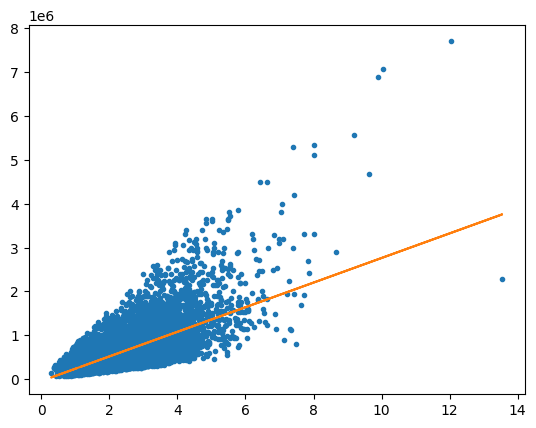

In [22]:
# YOUR CODE HERE
plt.plot(sales['sqft_living'], sales['price'], '.')
plt.plot(sqft_power_1, pred_priced1, '-')
plt.show()

***Question 13.*** Fit a degree-2 model, i.e., one where price is a function of `sqft_living` and its square. Print the learned coefficients (3 values in total). Plot the model along with a scatter plot of the entire sales data set.

<AxesSubplot: xlabel='x', ylabel='y'>

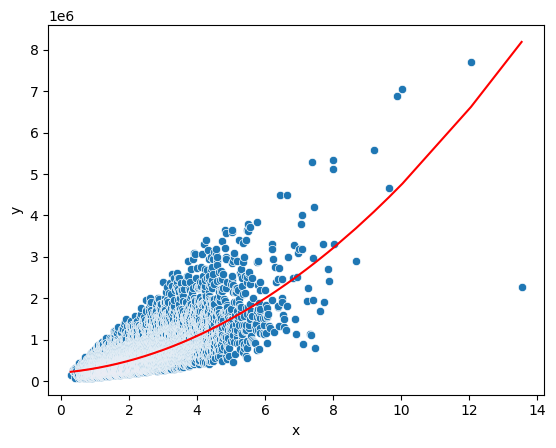

In [23]:
# YOUR CODE HERE
Xd2,yd2 = polynomial_matrix(sales,'sqft_living',2,'price')
wd2 = multiple_regression_closed(Xd2, yd2)
pred_priced2 = predict_target(Xd2, wd2)
df_12 = pd.DataFrame({'x': sales['sqft_living'], 'y': yd2})
df_22 = pd.DataFrame({'x': Xd2['power_1'], 'y': pred_priced2})
sns.scatterplot(df_12, x='x', y='y')
sns.lineplot(df_22, x='x', y='y', color = 'red')

***Question 14.*** Repeat with a polynomial of degree 3.

<AxesSubplot: xlabel='x', ylabel='y'>

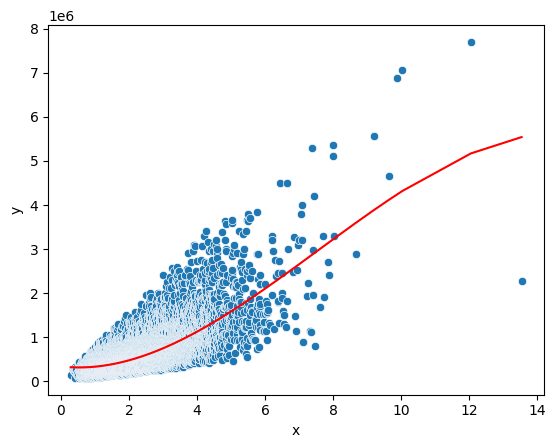

In [24]:
# YOUR CODE HERE
Xd3,yd3 = polynomial_matrix(sales,'sqft_living',3,'price')
sqft_power_3 = Xd3['power_3']
wd3 = multiple_regression_closed(Xd3, yd3)
pred_priced3 = predict_target(Xd3, wd3)
df_13 = pd.DataFrame({'x': sales['sqft_living'], 'y': yd3})
df_23 = pd.DataFrame({'x': Xd3['power_1'], 'y': pred_priced3})
sns.scatterplot(df_13, x='x', y='y')
sns.lineplot(df_23, x='x', y='y', color = 'red')

***Question 15.*** Now with degree 10

<AxesSubplot: xlabel='x', ylabel='y'>

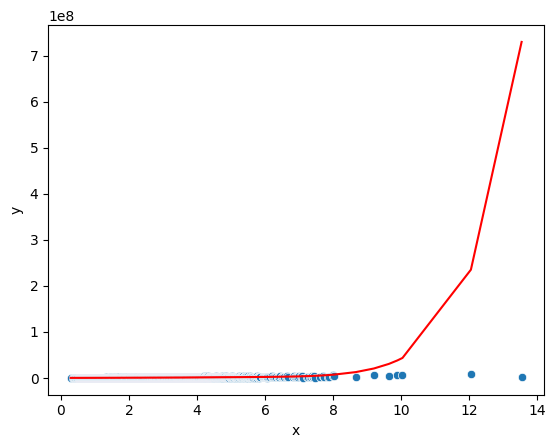

In [25]:
# YOUR CODE HERE
Xd10,yd10 = polynomial_matrix(sales,'sqft_living',10,'price')
sqft_power_10 = Xd10['power_10']
wd10 = multiple_regression_closed(Xd10, yd10)
pred_priced10 = predict_target(Xd10, wd10)
df_110 = pd.DataFrame({'x': sales['sqft_living'], 'y': yd10})
df_210 = pd.DataFrame({'x': Xd10['power_1'], 'y': pred_priced10})
sns.scatterplot(df_110, x='x', y='y')
sns.lineplot(df_210, x='x', y='y', color = 'red')

***Question 16.*** Which model seems to be the most successful. Which, if any, seems to overfit? 

Degree 3 seems to fit best. Degree 10 overfits the data by tring to go through every point.

### Using different training sets to explore variance
Let's now explore what happens if we change the training set. Do we expect to get pretty much the same model everytime?

We're going to split the sales data into four subsets of roughly equal size. Then you will estimate a 15th degree polynomial model on all four subsets of the data, print the coefficients and plot the resulting fit (as we did above).

To split the sales data into four subsets, we perform the following steps:
* First split sales into 2 subsets 
* Next split the resulting subsets into 2 subsets each.

Recall that the `sample` method allows you to select a random subset of a frame specified by a desired fraction. Set `random_state=0` so that different users get consistent results.

***Question 17.*** Create 4 training sets (`set_1`, `set_2`, `set_3`, `set_4`) of approximately equal size. 

In [26]:
# YOUR CODE HERE
bigset_1 = sales.sample(frac=0.5, random_state=0)
bigset_2 = sales.drop(bigset_1.index)
set_1 = bigset_1.sample(frac=0.5, random_state=0)
set_2 = bigset_1.drop(set_1.index)
set_3 = bigset_2.sample(frac=0.5, random_state=0)
set_4 = bigset_2.drop(set_3.index)

set_1 = set_1.reset_index(drop=True)
set_2 = set_2.reset_index(drop=True)
set_3 = set_3.reset_index(drop=True)
set_4 = set_4.reset_index(drop=True)

set_1 = set_1.sort_values(['sqft_living', 'price'])
set_2 = set_2.sort_values(['sqft_living', 'price'])
set_3 = set_3.sort_values(['sqft_living', 'price'])
set_4 = set_4.sort_values(['sqft_living', 'price'])

***Question 18.*** Fit a 10th degree polynomial on set_1, set_2, set_3, and set_4 using sqft_living to predict prices. Print the coefficients and make a plot of the resulting model. 

[  709470.95 -2770036.08  6028684.19 -6383543.06  3918809.83 -1483520.75
   356123.48   -54051.79     5001.61     -256.55        5.58]
[  25624.85  465936.52 -220426.67   44162.09   -4690.4    10810.26
   -5277.31    1063.29    -106.49       5.27      -0.1 ]
[  983445.79 -3728642.19  7778622.44 -8409305.94  5429167.53 -2201408.37
   572506.19   -94878.82     9644.67     -546.08       13.15]
[  1168354.04  -5040549.75  10746398.56 -11830340.94   7731336.95
  -3159016.84    824078.27   -136417.22     13800.13      -775.21
        18.48]


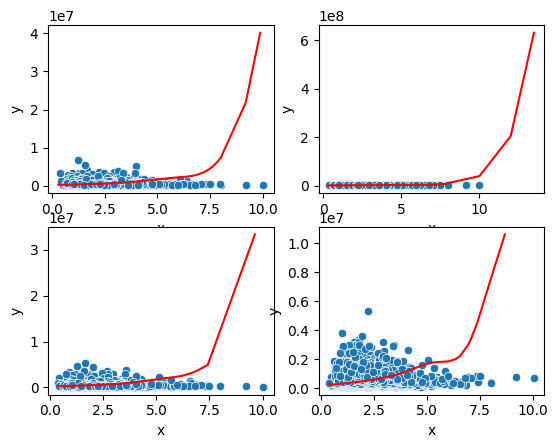

In [27]:
# YOUR CODE HERE
fig, ax = plt.subplots(2,2)

Xd101,yd101 = polynomial_matrix(set_1,'sqft_living',10,'price')
wd101 = multiple_regression_closed(Xd101, yd101)
pred_priced101 = predict_target(Xd101, wd101)
df_1101 = pd.DataFrame({'x': sales['sqft_living'], 'y': yd101})
df_2101 = pd.DataFrame({'x': Xd101['power_1'], 'y': pred_priced101})
sns.scatterplot(df_1101, x='x', y='y', ax = ax[0,0])
sns.lineplot(df_2101, x='x', y='y', color = 'red', ax = ax[0,0])

Xd102,yd102 = polynomial_matrix(set_2,'sqft_living',10,'price')
wd102 = multiple_regression_closed(Xd102, yd102)
pred_priced102 = predict_target(Xd102, wd102)
df_1102 = pd.DataFrame({'x': sales['sqft_living'], 'y': yd102})
df_2102 = pd.DataFrame({'x': Xd102['power_1'], 'y': pred_priced102})
sns.scatterplot(df_1102, x='x', y='y', ax = ax[0,1])
sns.lineplot(df_2102, x='x', y='y', color = 'red', ax = ax[0,1])

Xd103,yd103 = polynomial_matrix(set_3,'sqft_living',10,'price')
wd103 = multiple_regression_closed(Xd103, yd103)
pred_priced103 = predict_target(Xd103, wd103)
df_1103 = pd.DataFrame({'x': sales['sqft_living'], 'y': yd103})
df_2103 = pd.DataFrame({'x': Xd103['power_1'], 'y': pred_priced103})
sns.scatterplot(df_1103, x='x', y='y', ax = ax[1,0])
sns.lineplot(df_2103, x='x', y='y', color = 'red', ax = ax[1,0])

Xd104,yd104 = polynomial_matrix(set_4,'sqft_living',10,'price')
wd104 = multiple_regression_closed(Xd104, yd104)
pred_priced104 = predict_target(Xd104, wd104)
df_1104 = pd.DataFrame({'x': sales['sqft_living'], 'y': yd104})
df_2104 = pd.DataFrame({'x': Xd104['power_1'], 'y': pred_priced104})
sns.scatterplot(df_1104, x='x', y='y', ax = ax[1,1])
sns.lineplot(df_2104, x='x', y='y', color = 'red', ax = ax[1,1])

print(wd101)
print(wd102)
print(wd103)
print(wd104)

***Question 19.*** Do the plots look similar for all four models? Why or why not? Are the signs (positive or negative) of the coefficients the same? Why or why not?

They look almost the same as the models are trying to fit all the points with the same complexity. The coefficients of set_1, set_3 and set_4 have the same signs.

## Selecting a Polynomial Degree
Whenever we have a hyperparameter like the degree of the polynomial there is a standard approach to select these parameters: by using a *validation set*. (We will discuss alternatives in class).

***Question 20.*** Split the sales dataset 3-way into training set (45%), validation set (45%), and test set (10%) as follows:

* Split the sales data into 2 sets: `training_and_validation` and `testing`. 
* Further split the first set into two sets: `training` and `validation`. 

Initialize `random_state` to 3 in order to obtain consistent results for different users.

In [28]:
# YOUR CODE HERE
training_and_validation = sales.sample(frac=0.9, random_state=3)
testing = sales.drop(training_and_validation.index)
training = training_and_validation.sample(frac=0.5, random_state=3)
validation = training_and_validation.drop(training.index)

testing = testing.reset_index(drop=True)
training = training.reset_index(drop=True)
validation = validation.reset_index(drop=True)

testing = testing.sort_values(['sqft_living', 'price'])
training = training.sort_values(['sqft_living', 'price'])
validation = validation.sort_values(['sqft_living', 'price'])

***Question 21.*** You will now select an appropriate degree with code that does the following:
1. For degree $1, 2,\ldots,10$:
    * Build a frame of polynomial data of train_data['sqft_living'] at the current degree
    * Add train_data['price'] to the polynomial frame
    * Learn a polynomial regression model to sqft vs price with that degree on *training data*
    * Compute and print the MSE on *validation data* (you will want to use your prediction function from above, remember to make a polynomial frame using validation data.)
2. Report which degree had the lowest RSS on validation data (remember python indexes from 0)
Comment on the magnitude of the model coefficients as the complexity of the model increases.

In [29]:
# YOUR CODE HERE
RSS_li = []
for i in range(1, 11):
    X_train_,y_train_ = polynomial_matrix(training,'sqft_living',i,'price')
    w_train_ = multiple_regression_closed(X_train_,y_train_)
    X_val_,y_val_ = polynomial_matrix(validation,'sqft_living',i,'price')
    pred_price_val_ = predict_target(X_val_,w_train_)
    print(f'degree {i}: {MSE(y_val_,  pred_price_val_)}')
    RSS_li.append((np.dot(y_val_ - pred_price_val_, y_val_ - pred_price_val_), f'degree {i}'))

print(min(RSS_li))

degree 1: 69537222800.2702
degree 2: 61507725386.643326
degree 3: 61505507053.598305
degree 4: 61476208985.309006
degree 5: 61122729831.52384
degree 6: 61200907763.2264
degree 7: 61278901107.18737
degree 8: 61376145512.17079
degree 9: 63724604673.70276
degree 10: 127037959990.19641
(594479670341400.9, 'degree 5')


Degree 5 has the lowest RSS.

Now that you have chosen the degree of your polynomial using validation data, evaluate this model on the test data.

***Question 22.*** What is the RMSE of the *test data* for the model chosen using the *validation data*?

1332842.1523746443

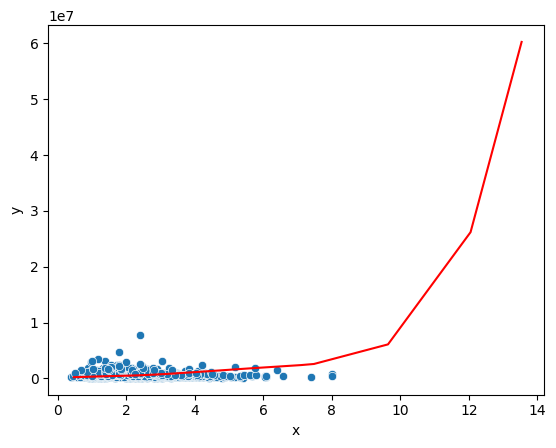

In [36]:
# YOUR CODE HERE
X_train_,y_train_ = polynomial_matrix(training,'sqft_living',5,'price')
w_train_ = multiple_regression_closed(X_train_,y_train_)

X_test_,y_test_ = polynomial_matrix(testing,'sqft_living',5,'price')
w_test_ = multiple_regression_closed(X_test_,y_test_)
pred_price_test_ = predict_target(X_test_,w_train_)
df_test1 = pd.DataFrame({'x': sales['sqft_living'], 'y': y_test_})
df_test2 = pd.DataFrame({'x': X_test_['power_1'], 'y': pred_price_test_})
sns.scatterplot(df_test1, x='x', y='y')
sns.lineplot(df_test2, x='x', y='y', color = 'red')

rsme_test = math.sqrt(MSE(y_test_, pred_price_test_))
rsme_test

***Question 23.*** Using everything you have learned in this class, create a new model that improves the test RMSE by a factor of at least 4. This will require some experimentation on your part.

290335.0051631996

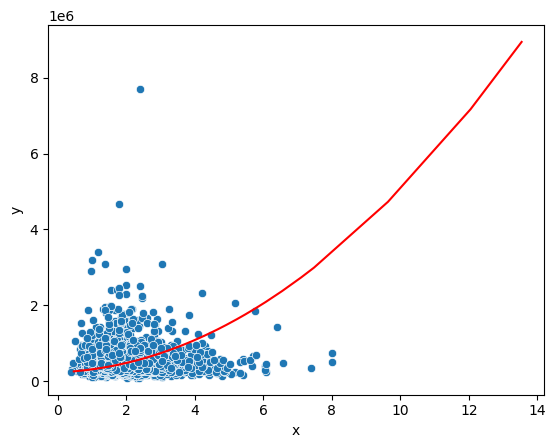

In [37]:
# YOUR CODE HERE
X_train_,y_train_ = polynomial_matrix(training,'sqft_living',3,'price')
w_train_ = multiple_regression_closed(X_train_,y_train_)

X_test_,y_test_ = polynomial_matrix(testing,'sqft_living',3,'price')
w_test_ = multiple_regression_closed(X_test_,y_test_)
pred_price_test_ = predict_target(X_test_,w_train_)
df_test1 = pd.DataFrame({'x': sales['sqft_living'], 'y': y_test_})
df_test2 = pd.DataFrame({'x': X_test_['power_1'], 'y': pred_price_test_})
sns.scatterplot(df_test1, x='x', y='y')
sns.lineplot(df_test2, x='x', y='y', color = 'red')

rsme_test = math.sqrt(MSE(y_test_, pred_price_test_))
rsme_test